# Dealing with Gibbs Oscilations

When solving the hyperbolic governing equation,

$$\frac{\partial u}{\partial t}=C\left(\frac{\partial u}{\partial x}\right)$$

with a 2nd order (or higher) method, Godunov's theorem, tells us we will see spurious oscilations arround any steep gradients.  We saw this when we looked at the solution from the Lax-Wendroff scheme.  We'll set up the Lax-Wendroff scheme and use it to solve the test problem.

We start (as ever) with the Grid class.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

def one(t):
    '''simple function of x and t which allways returns 1.0
    This function is used as a place keeper for the 
    Dirichlet boundary condition.'''
    return 1.0


class Grid:
    '''Class defining the grid for a 1D hyperbolic solver.  Solving
    
    $$\frac{\partial u}{\partial t}=C\left(\frac{\partial u}{\partial x}\right)$$

    The grid object contains the number of grid points (Ni), left
    and right ordinates (x0 and x1), flags for wether the boundaries
    are Dirichlet or Neumann boundary conditions and functions for
    plotting the solution both at a particular time level and in the
    form of an x-t plot.  The grid also contains the solution vector (u)
    which is stored as an array with differnt time levels, together with
    the number of time steps N_t and the (uniform) time step Delta_t.
    
    Written by Prof David Ingram, School of Engineering
    (c) 2021 The University of Edinburgh
    Licensed under CC-BY-NC.
    '''
    
    DIRICHLET_BC = 0
    NEUMANN_BC = 1
    PERIODIC_BC = 2

    BC_NAME = ['left', 'right']
    
    def __init__(self,ni):
        # set up information about the grid
        self.x0 = 0.0 #  left
        self.x1 = 1.0 #  right
        self.N_i = ni # grid points in i direction
        self.N_t = 0 # how many time steps have we performed
        self.Delta_t = 0.0 # no dt value yet
        self.C = 1.0 # advection speed (Celarity)

        # initialse x,y and u arrays
        self.u = np.zeros((1,ni))
        self.x = np.zeros(ni)
        self.t = np.zeros(1)

        # boundary conditions (left and right )
        self.BC = [ self.DIRICHLET_BC, self.DIRICHLET_BC ]
        self.BC_fun = [ one, one ]

    def set_x0(self,x0):
        self.x0 = x0
    
    def set_x1(self,x1):
        self.x1 = x1
        
    def set_advection_speed(c):
        self.C = c
        
    def generate(self,Quiet=True):
        '''generate a uniformly spaced grid covering the domain from the
        x0 to the x1.  We are going to do this using linspace from
        numpy to create a list of x ordinates.'''
        self.x = np.linspace(self.x0, self.x1, self.N_i)
        if not Quiet:
            print(self)

    def initial_conditions(self,fun):
        '''set the initial conditions by calling the specified function
        fun(x) at every ordinate'''
        for i in range(self.N_i):
            self.u[0,i] = fun(self.x[i])

    def Delta_x(self):
        # calculate delta x
        return self.x[1]-self.x[0]
    
    def set_Neumann_bc(self,side):
        '''specify Neuman boundayr conditions'''
        try:
             self.BC[self.BC_NAME.index(side)] = self.NEUMANN_BC
        except:
             print('error {} must be one of {}'.format(side,self.BC_NAME))
     
    def set_Dirichlet_bc(self,side,fun):
        '''set the Dirichlet boundary condition.  As well as the side
        this must be passed a function fun(t) which returns the value
        associated with the Dirichlet boundary at the time t.'''
        try:
            self.BC[self.BC_NAME.index(side)] = self.DIRICHLET_BC
        except:
            print('error {} must be one of {}'.format(side,self.BC_NAME))
        self.BC_fun[self.BC_NAME.index(side)] = fun
        
    def set_periodic_bc(self,side):
        '''Specify parabolic boundary conditions'''
        try:
             self.BC[self.BC_NAME.index(side)] = self.PERIODIC_BC
        except:
             print('error {} must be one of {}'.format(side,self.BC_NAME))

    def set_Delta_t(self,Coutrant_number):
        # set the time step using the Courant-Friedirchs-Lewey condition
        self.Delta_t = Coutrant_number * self.Delta_x()/(abs(self.C))
            
    def apply_BC(self,t):
        '''Apply the left and right boundary conditions to the values in
        the latest value of u at the current time level'''
        # left boundary
        if self.BC[0]==self.PERIODIC_BC:
            self.u[-1,0] = self.u[-1,-2]
        elif self.BC[0]==self.NEUMANN_BC:
            self.u[-1,0] = self.u[-1,2]
        else:
            self.u[-1,0] = self.BC_fun[0](t)
        
        # right
        if self.BC[1]==self.PERIODIC_BC:
            self.u[-1,-1] = self.u[-1,1]
        elif self.BC[1]==self.NEUMANN_BC:
            self.u[-1,-1] = self.u[-1,-3]
        else:
            self.u[-1,-1] = self.BC_fun[1](t)
    
    def integrate(self,t_stop,solver):
        '''call the integrator defined by solver to integrate
        the solution from t=0 to t=t_stop.  Provided the more
        than 10 timesteps are calculated the results will be
        stored at 10 intermediate times.'''
        
        time = self.t[-1]
        o_time = (t_stop-time)/50 # time for intermediate outputs
        
        # output to the user
        print('Integrating from {:.3g} to {:.3g} seconds Δt={:.3g} :'
              .format(time, t_stop,self.Delta_t),end='')
        
        # save the initial conditions as the first saved result
        #if (time==0.0): 
        #    self.u = np.vstack([self.u, self.u])

        # time loop
        while True:
            # short time step at the end
            dt = min(self.Delta_t,t_stop-time)
            
            # update the boundary conditions and call the solver
            self.apply_BC(time)
            
            # update the time and save the time and results
            time += dt
            self.u[-1] = solver(self)
            self.t[-1] = time

            # progress monitor
            if (time >= o_time) & (time<t_stop):
                print('#',end='')
                o_time += t_stop/50
                self.t = np.append(self.t, time)
                self.u = np.vstack([self.u, self.u[-1]])
                self.N_t += 1
 
            # are we done
            if time >= t_stop:
                print('. ')
                break
        
    def plot(self,title):
        '''plot the solution at the current time level.  If there are
        more than 60 points in the x-direction then a line is used.'''
        if self.N_i<60:
            plt.plot(self.x,self.u[self.N_t],'ob')
        else:
            plt.plot(self.x,self.u[self.N_t],'-b')
        plt.title(title+', t={:.3f}'.format(self.t[-1]))
        plt.show()
        
    def report_BC(self):
        '''compile a string listing the boundary conditions on each side.
        We build up a string of two {side name}: {BC type} pairs and
        return it'''
        
        # initialise the string
        string = ''
        
        # loop over the sides
        for side in range(2):
            # add the side name
            string = string + self.BC_NAME[side]
            # and the bounday condition type
            if self.BC[side] == self.DIRICHLET_BC:
                string = string + ': Dirichlet, '
            elif self.BC[side] == self.NEUMANN_BC:
                string = string + ': Neumann, '
            elif self.BC[side] == self.PERIODIC_BC:
                string = string + ': Periodic, '
        return string[:-2] +'.' # lose the last comma and space.
    
    def __str__(self):
        # describe the object when asked to print it
        describe = 'Hyperbolic linear advection, C={:.3g}\n'.format(self.C)
        describe += 'Uniform {} node grid from {} to {}.\n'.format(self.N_i, self.x0, self.x1)
        describe += 'Boundaries conditions are - ' + self.report_BC()
        if self.N_t==0:
            describe += '\nInitial conditions at t=0.0, Δt={:.3g} seconds'.format(self.Delta_t)
        else:
            describe += '\n{} steps from t=0.0 to t={:.3g}, Δt={:.3g} seconds'.format(self.N_t+1,self.N_t*self.Delta_t,self.Delta_t)
        return describe

### A test problem
We have a 1m long domain from _x_=0.0 to _x_=1.0 with C=1.0.  The initial conditions are

$$u(x,0)=\begin{cases}
\sin^42\pi x &0\le x < \frac12\\
1 & \frac46\le x <\frac56\\
0 & otherwise.\end{cases}$$

and we have perioduc boundary conditions at _x_=0.0 and _x_=1.0.

The analytical solution is that the solution should match the 
Let's set it up

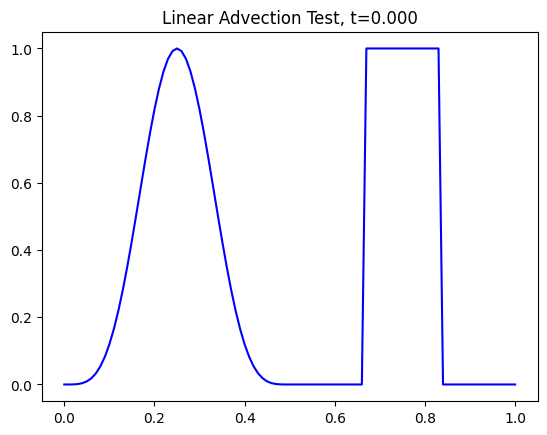

Hyperbolic linear advection, C=1
Uniform 101 node grid from 0.0 to 1.0.
Boundaries conditions are - left: Periodic, right: Periodic.
Initial conditions at t=0.0, Δt=0.009 seconds


In [2]:
def u_init(x):
    ''' Function to set the initial conditions for the test.
    x is a real number
    we return u(x)'''
    
    if x<0.5:
        u0 = np.sin(2*np.pi*x)**4
    elif x>=0.66667 and x<=0.83333:
        u0 = 1.0
    else:
        u0 = 0.0
    return u0

test = Grid(101)
test.generate()
test.set_Delta_t(0.9)
test.set_periodic_bc('right')
test.set_periodic_bc('left')
test.initial_conditions(u_init)
test.plot('Linear Advection Test')
print(test)


## Lax-Wendroff Scheme

Peter Lax and Burton Wendroff designed a scheme based on using 2nd
order central difference approximations for both $\delta_x$ and
$\delta_{xx}$, i.e.

$$\delta_x.u_i^n=\frac{u_{i+1}^n-u_{i-1}^n}{2\Delta x}\mbox{ and }
\delta_{xx}.u_i^n=\frac{c_{i+1}^n-2u_i^n+u_{i-1}^n}{\Delta x^2}.$$ 

These choices lead to the so-called __Lax-Wendroff__ scheme,

$$
u_i^{n+1}=u_i^n-\frac{C\Delta t}{2\Delta x}\left(u_{i+1}^n-u_{i-1}^n\right)
+\frac{C^2\Delta t^2}{2\Delta x^2}\left(u_{i+1}^n-2u_i^n+u_{i-1}^n\right),
$$

__MacCormack's__ version of this scheme re-formulates it as a predictor-corrector scheme and is a little simpler to implement.   

$$ u^p_i = u ^n_i - \frac{a\Delta t}{\Delta x}\left(u^n_i - u^n_{i-1}\right) $$
$$u^{n+1}_i = \frac{u^p_i+u^n_i}{2} - \frac{a\Delta t}{2\Delta x}\left(u^p_{i+1} - u^p_i\right) $$ 



Integrating from 0 to 1 seconds Δt=0.009 :#################################################. 
Hyperbolic linear advection, C=1
Uniform 101 node grid from 0.0 to 1.0.
Boundaries conditions are - left: Periodic, right: Periodic.
50 steps from t=0.0 to t=0.441, Δt=0.009 seconds


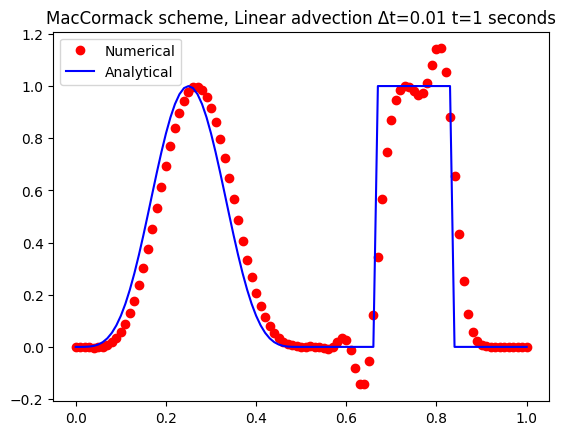

In [3]:
def MacCormack(grid):
    '''Perform one time step using the 2nd order MacCormack 
    predictor corrector method which is equivalent to the 
    classical Lax-Wendroff scheme.'''

    # coefficient
    Rx = grid.C*grid.Delta_t/(2*grid.Delta_x())
    
    # copy u values
    u = grid.u[-1].copy()

    # Predictor
    up = u - 2* Rx * (u - np.roll(u,+1)) 
    # Corrector
    u = (u+up)/2 - Rx * (np.roll(up,-1)-up)

    return u

# set up the test problem
test = Grid(101)
test.generate()
test.set_Delta_t(0.9)
test.set_periodic_bc('right')
test.set_periodic_bc('left')
test.initial_conditions(u_init)

# Lets do one whole rotation
test.integrate(1, MacCormack)
print(test)

# construct the analytical solution
u_exact = []
for x_i in test.x:
    u_exact.append(u_init(x_i))

# plot it
plt.plot(test.x,test.u[-1],'ro',label='Numerical')
plt.plot(test.x,u_exact,'b-',label='Analytical')
plt.title('MacCormack scheme, Linear advection Δt={:.3g} t={:.3g} seconds'.format(test.Delta_x(),test.t[-1]))
plt.legend()
plt.show()


### TVD Schemes

We can clearly see the oscilations around the top hat and we are overpredicting the magnitude of the step by about 20%.   We know that the 2nd order schemes is trying to interpolate the top hat function using peicewise quadratic interpolation, this causes the spurious oscillations we can see.    

In his 1959 paper Sergei K Godunov stated 
>  all (linear) methods of  greater than first order accuracy will produce spurious oscillations in the vicinity of large gradients.

From 1980 onwads a lot of work was done on designing schemes which satistfied the Total Variation Diminishing (TVD) property of hyperbolic conservation laws.  This property states that no new extreema (minima or maxima) can be introduced.  In his 1983 paper Ami Harten defined the Total Variation (TV) of the solution as

$$TV(u^n) = \sum_i \left| u^n_{i+1}-u^n_i \right| $$

Any scheme is said to be TVD if and only if

$$TV(u^{n+1})\le TV(u^n)$$

Harten, Davis and others went on to derive a series of numerical schemes which applied a correction to schemes like the Lax-Wendroff scheme to ensure the TVD property was preserved in regions where the gradient was steep.

The corrected version of the Lax-Wendroff scheme is
$$u^{n+1}_i= L_{LW}(\Delta t).u^n_i
+\left(G^+(r_i)+G^-(r_{i+1})\right)\Delta u^n_{i+\frac12}
-\left(G^+(r_{i-1})+G^-(r_i)\right)\Delta u^n_{i-\frac12}$$

where
$$G(r^\pm_i)=\frac12|\nu|(1-|\nu|)(1-\Phi(r^\pm_i)),$$
$$r^\pm_i=\frac{\Delta u^n_{i\mp\frac12}}{\Delta u^n_{i\pm\frac12}},$$
$$\Delta u_{i+\frac12}=u_{i+1}-u_i,\, \Delta u_{i-\frac12}=u_i-u_{i-1},\,\nu=\frac{u\Delta t}{\Delta x},$$
 $L_{LW}(\Delta t).u^n_i$ is the original Lax-Wendroff scheme and $\Phi(r)$ is the flux limiter function.  This function must have certain properties (see lecture slides).  
 
These schemes are mathematically complex to derive and can be tricky to implement.  However let's have a go....

**Note**

I'm going to use a usefull feature of <code>numpy</code> to make the code run quickly.  In functions like <code>numpy.maximum()</code> and <code>numpy.divide()</code> we can use the <code>where</code> keyword to provide a condition which means the function will only be applied when the condition is true.  If we have also used the <code>out</code> keyword to specify an array then these values will be returned when the conidition is false.

This means that
```
return np.maximum(np.minimum(r*k, np.ones_like(r)), 
                      np.minimum(r, k*np.ones_like(r)),
                      out=np.zeros_like(r),
                      where=r>0) 
```
will return $\max(\min(rk,1),\min(r,k))$ when $r>0$ and zero otherwise.  This is the _k limiter_ (see lecture slides) and will be very computationally efficient.



In [4]:
def Phi(r):
    # this is the TVD limiter applied to the gradient ration, r.  We are going
    # to use the k-limiter, if k=1 this is the minmod limiter and if k=2 it
    # is the SuperB limiter, otherwise it's somewhere between the two.
    #
    # we are going to use the where aregument to mask -ve values of r.
    k=1.5
    ones = np.ones_like(r)
    zeros = np.zeros_like(r)
    
    return np.maximum(np.minimum(r*k, ones), 
                      np.minimum(r, k*ones),
                      out=zeros,
                      where=r>0) 

def macTVD(grid):
    # perform one itteration of the MacCormack scheme with the TVD correction
    # added. 
    
    # copy u values and set an array of ones
    u0 = grid.u[-1].copy()
    ones = np.ones_like(u0)

    # compute the unmodifid solution
    u1 = MacCormack(grid)
    
    # now we need to know the Courant number, nu.  For a system of equations
    # we need nu in each grid cell but for linear advection on a uniform mesh
    # it's constant. We will also find the courant number function
    
    nu = grid.C * grid.Delta_t / grid.Delta_x()
    if nu>0.5:
        c_nu = nu * (1 - nu)
    else:
        c_nu = 0.25
    
    # now we compute the gradient in plus direction
    du_plus = np.roll(u0,-1) - u0
    
    # and the gradient in the minus direction
    du_minus = u0 - np.roll(u0,+1) 
    
    # now compute the gradient ratios, we are going to define a lambda function to calculate
    # the gradient.  This uses numpy divided with a where filter to stop overflow and division by
    # zero errors (such gradients will be zero).
    R = lambda a,b : np.divide(a, b, 
                               out=1e5*np.ones_like(b), 
                               where=~np.isclose(b, np.zeros_like(b))) 
    
    r_plus = R(du_plus, du_minus)
    r_minus = R(du_minus, du_plus)
    
    # now we can limit the gradients
    g_plus = ones - Phi(r_plus)
    g_minus = ones - Phi(r_minus)
    
    # now we can compute the TVD correction
    tvd = c_nu * ((g_plus + np.roll(g_minus, -1)) * du_plus  - 
                (np.roll(g_plus, +1) + g_minus) * du_minus) / 2
    
    # and apply it
    return u1 - tvd    
    

Integrating from 0 to 1 seconds Δt=0.009 :#################################################. 
Hyperbolic linear advection, C=1
Uniform 101 node grid from 0.0 to 1.0.
Boundaries conditions are - left: Periodic, right: Periodic.
50 steps from t=0.0 to t=0.441, Δt=0.009 seconds


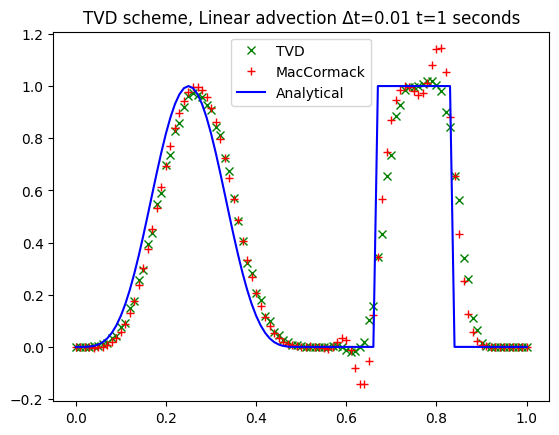

In [8]:
# lets see if it works
test2 = Grid(101)
test2.generate()
test2.set_Delta_t(0.9)
test2.set_periodic_bc('right')
test2.set_periodic_bc('left')
test2.initial_conditions(u_init)

# Lets do one whole rotation
test2.integrate(1, macTVD)
print(test2)

# plot it
plt.plot(test2.x,test2.u[-1],'gx',label='TVD')
plt.plot(test.x,test.u[-1],'r+',label='MacCormack')
plt.plot(test.x,u_exact,'b-',label='Analytical')
plt.title('TVD scheme, Linear advection Δt={:.3g} t={:.3g} seconds'.format(test.Delta_x(),test.t[-1]))
plt.legend()
plt.show()


### Analysis

The TVD scheme has removed the spurious osciltions associated with the 2nd order MacCormak scheme (arround the top hat) but seems to work well arround the Gaussian bump.  we can now try it on a finer grid and run it for a bit longer.


Integrating from 0 to 3 seconds Δt=0.0018 :#################################################. 
Hyperbolic linear advection, C=1
Uniform 501 node grid from 0.0 to 1.0.
Boundaries conditions are - left: Periodic, right: Periodic.
50 steps from t=0.0 to t=0.0882, Δt=0.0018 seconds


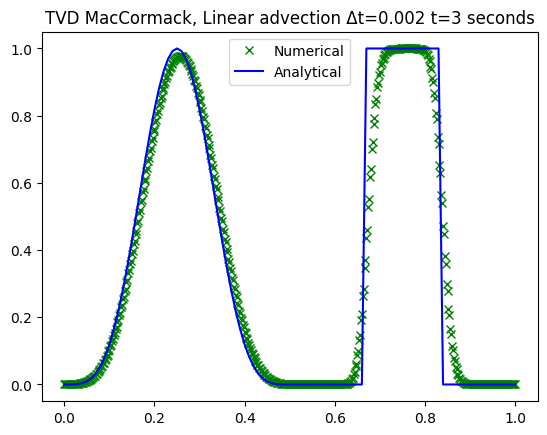

In [9]:
# Now use a finer grid 
test3 = Grid(501)
test3.generate()
test3.set_Delta_t(0.9)
test3.set_periodic_bc('right')
test3.set_periodic_bc('left')
test3.initial_conditions(u_init)

# Lets do three whole rotations
test3.integrate(3, macTVD)
print(test3)

# plot it
plt.plot(test3.x,test3.u[-1],'gx',label='Numerical')
plt.plot(test.x,u_exact,'b-',label='Analytical')
plt.title('TVD MacCormack, Linear advection Δt={:.3g} t={:.3g} seconds'.format(test3.Delta_x(),test3.t[-1]))
plt.legend()
plt.show()


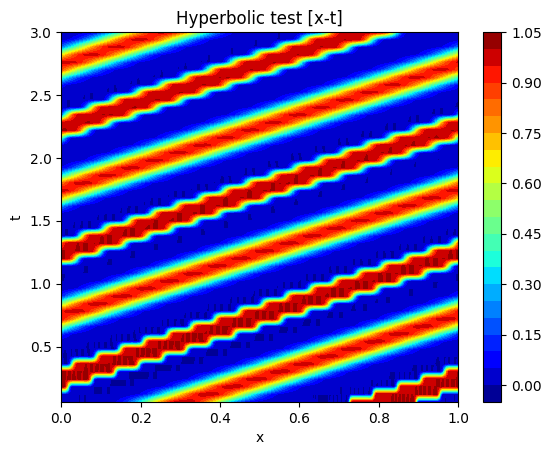

In [7]:
# finally draw the X-T plot
X,T = np.meshgrid(test3.x,test3.t)
fig, ax1 = plt.subplots()
cmap = plt.get_cmap('jet')
cf = ax1.contourf(X,T,test3.u,cmap=cmap, levels = 21)
fig.colorbar(cf, ax=ax1)
ax1.set_title('Hyperbolic test [x-t]')
ax1.set_xlabel('x')
ax1.set_ylabel('t')
plt.show()

## Exercise
Explore the effect of using other limiters, such as

* Davis, $\mathrm{minmod}(2r,1)$ 
* minmod, $\max(0,\min(r,1))$ 
* SuperB, $\max(0,\min(2r,1),\min(r,2))$, and
* Van Leer, $(r+|r|)/(1+|r|)$.

Try different periodic initial conditions (sine waves, etc) and advection speeds (e.g. $C=-1$)  and see what happens?
